## Correlated Walker—Functionality Demonstration

### 1. Simple Correlated Walk generation with Chi-Distribution Kernel

You have 15035.527344 MiB of free RAM
walker requires 39.672852 MiB of RAM
(1/50)
(2/50)
(3/50)
(4/50)
(5/50)
(6/50)
(7/50)
(8/50)
(9/50)
(10/50)
(11/50)
(12/50)
(13/50)
(14/50)
(15/50)
(16/50)
(17/50)
(18/50)
(19/50)
(20/50)
(21/50)
(22/50)
(23/50)
(24/50)
(25/50)
(26/50)
(27/50)
(28/50)
(29/50)
(30/50)
(31/50)
(32/50)
(33/50)
(34/50)
(35/50)
(36/50)
(37/50)
(38/50)
(39/50)
(40/50)
(41/50)
(42/50)
(43/50)
(44/50)
(45/50)
(46/50)
(47/50)
(48/50)
(49/50)


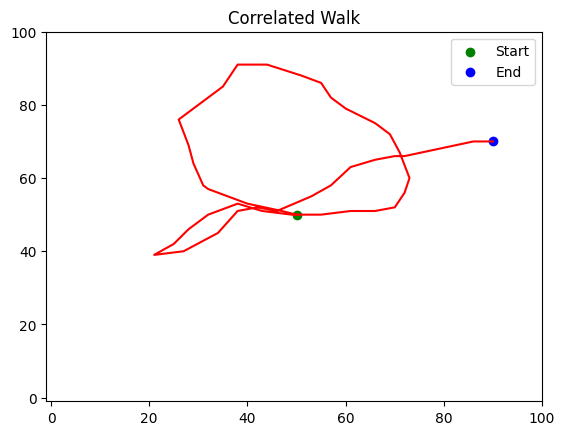

Debug: walk.length = 50
<xml><var name="_dummy_ipython_val"  />
<var name="_dummy_special_var"  />
<var name="path1" type="ndarray" qualifier="numpy" value="%5B%5B50 50%5D%2C %5B47 51%5D%2C %5B40 53%5D%2C %5B36 55%5D%2C %5B32 57%5D%2C %5B31 58%5D%2C %5B29 64%5D%2C %5B28 69%5D%2C %5B26 76%5D%2C %5B31 81%5D%2C %5B35 85%5D%2C %5B38 91%5D%2C %5B41 91%5D%2C %5B44 91%5D%2C %5B51 88%5D%2C %5B55 86%5D%2C %5B57 82%5D%2C %5B60 79%5D%2C %5B66 75%5D%2C %5B69 72%5D%2C %5B71 67%5D%2C %5B73 60%5D%2C %5B72 56%5D%2C %5B70 52%5D%2C %5B66 51%5D%2C %5B64 51%5D%2C %5B61 51%5D%2C %5B55 50%5D%2C %5B49 50%5D%2C %5B43 51%5D%2C %5B38 53%5D%2C %5B32 50%5D%2C %5B28 46%5D%2C %5B25 42%5D%2C %5B21 39%5D%2C %5B21 39%5D%2C %5B27 40%5D%2C %5B34 45%5D%2C %5B38 51%5D%2C %5B42 52%5D%2C %5B46 51%5D%2C %5B53 55%5D%2C %5B57 58%5D%2C %5B61 63%5D%2C %5B66 65%5D%2C %5B70 66%5D%2C %5B72 66%5D%2C %5B79 68%5D%2C %5B86 70%5D%2C %5B90 70%5D%5D" isContainer="True" shape="(50, 2)" arrayElementType="int64" />
<var name="walker" type="C

In [2]:

from random_walk_package.core.CorrelatedWalker import CorrelatedWalker

with CorrelatedWalker(T=50, W=100, H=100, D=8, S=7) as walker:
    walker.generate(start_x=50, start_y=50)
    path1 = walker.backtrace(end_x=90, end_y=70, plot=True)

### 2. Define custom kernels

1. **Pass a kernel matrix:**
   Provide a `numpy` array of type `float` containing the kernel weights, along with the corresponding step size `S`.
   The parameter `S` defines the kernel width as

   $\text{kernel\_width} = 2S + 1$

   The array must therefore contain exactly `kernel_width × kernel_width` elements.

2. **Specify the number of directions (`D`):**
   Pass `D` as the number of directions. The resulting kernel will consist of `D` rotated versions of the base kernel matrix.
   Each matrix for direction


   $d \in [0, D - 1]$


   corresponds to the base kernel rotated by

    $d \times \frac{360°}{D}$.




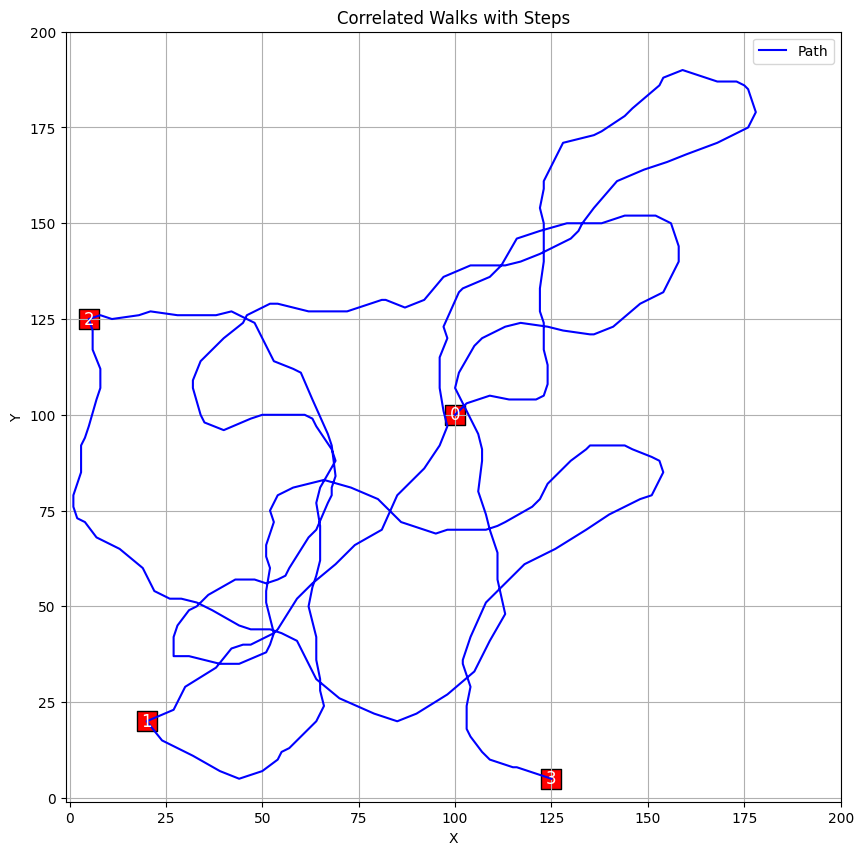

In [3]:
import numpy as np

S = 10
with CorrelatedWalker(T=100, W=200, H=200, D=8, S=7) as walker:
    x, y = np.meshgrid(np.arange(-S, S + 1), np.arange(-S, S + 1))
    angle = np.arctan2(y, x)
    radius = np.sqrt(x ** 2 + y ** 2)

    mask = (np.abs(angle) < np.deg2rad(30)) & (radius <= S)
    custom_kernel = np.exp(-0.5 * (radius / (S / 2)) ** 2) * mask
    custom_kernel /= custom_kernel.sum()

    walker.set_kernel(custom_kernel, S=S)
    steps = [(100, 100), (20, 20), (5, 125), (125, 5)]
    walker.multistep_walk(steps=steps, plot=True)

## 3. Terrain-based Walks

- **Terrain objects** influence how the walker moves. They are defined by text files containing 'delim'-separated MESA landcover values.
- Different **landmark types** receive different kernel parameters. In this example, water areas are avoided.
  You can customize the kernel mapping based on the animal type or use case.
  There are five presets: `LIGHT`, `MEDIUM`, `HEAVY`, `AMPHIBIAN`, and `AIRBORNE`, each with predefined kernel parameters.
  Kernel parameters include `step_size`, `diffusity`, `width`, and `height`, as well as `transition_probabilities` between different landmarks and can be fully customized for individual landmarks.

> **Note:**
> When a terrain and its corresponding kernel mapping are passed to the `Walker` object, the walker takes ownership of their allocated memory.
> This means that once the walker goes out of scope, the terrain object is automatically freed on the C side.
> This behavior is intentional and ensures that Python users do not need to perform manual memory management.

In [4]:
from random_walk_package.bindings.data_structures.kernel_terrain_mapping import *
from random_walk_package.bindings import *

terrain = create_terrain_map('terrain_baboons.txt', delim=' ')
print(terrain.contents.width, terrain.contents.height)
kernel_mapping = create_correlated_kernel_parameters(animal_type=MEDIUM, base_step_size=7)
set_landmark_mapping(kernel_mapping, GRASSLAND, is_brownian=False, step_size=10, directions=8, diffusity=1)
set_landmark_mapping(kernel_mapping, TREE_COVER, is_brownian=False, step_size=2, directions=12, diffusity=2.6)
set_forbidden_landmark(kernel_mapping, WATER)

#### Now the terrain-based walk can be created using the parameters defined above
(If no custom kernel mapping is provided, a default one will be used.)

In [5]:
walker = CorrelatedWalker(T=200, terrain=terrain, kernel_mapping=kernel_mapping)
walker.generate_from_terrain(start_x=50, start_y=50)

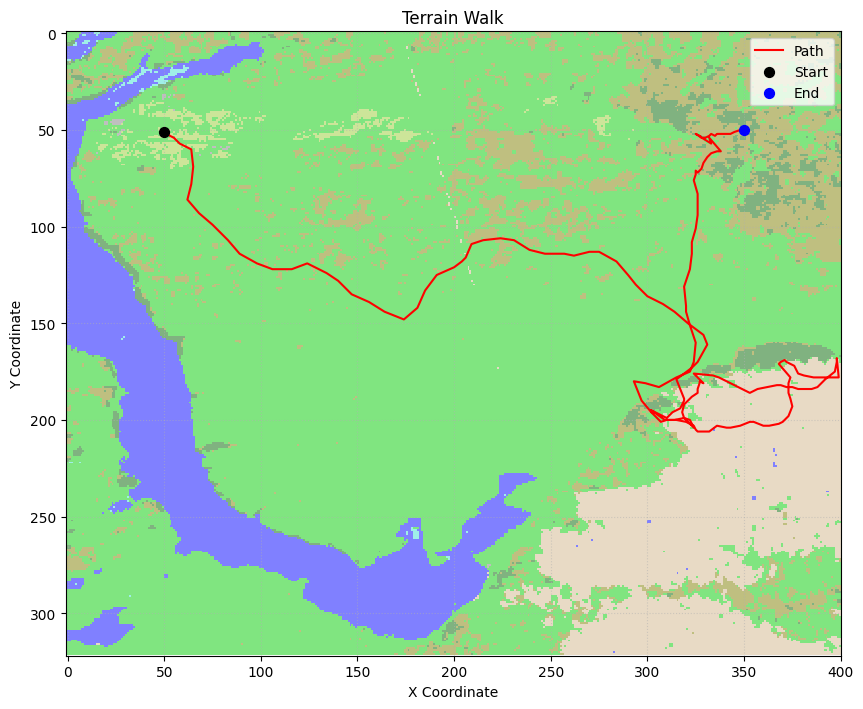

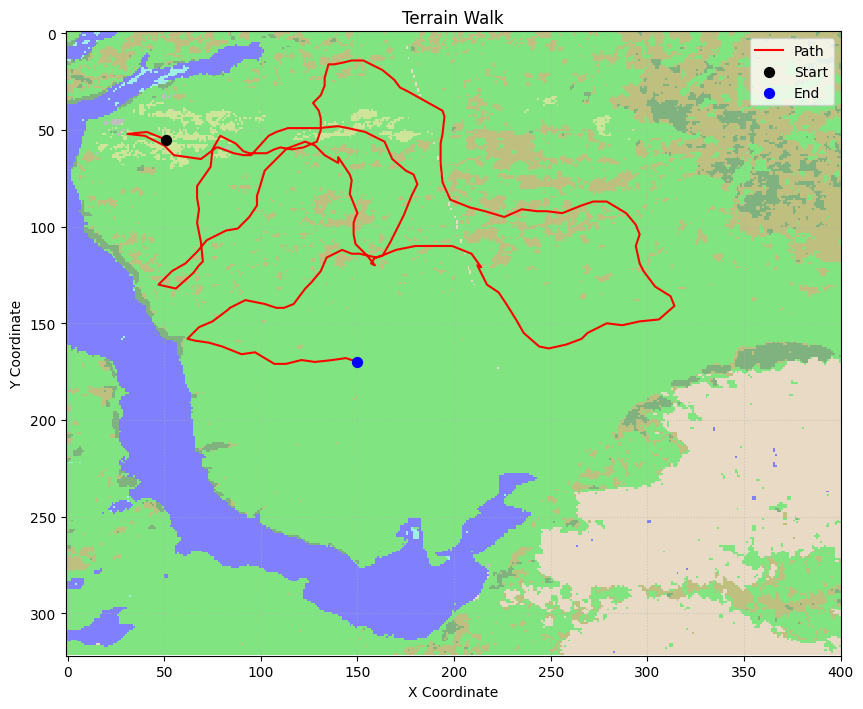

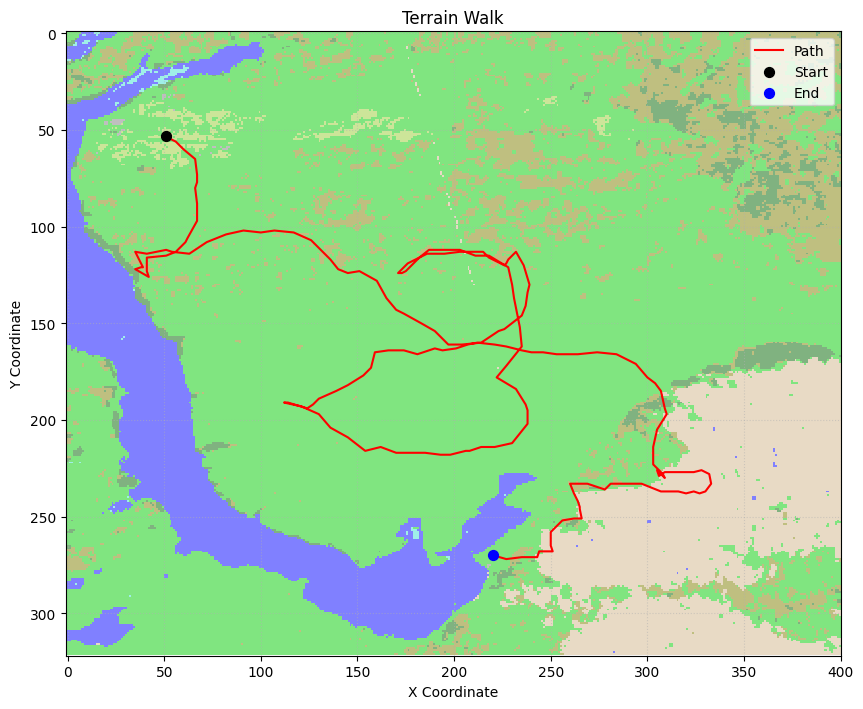

In [18]:
path3 = walker.backtrace_from_terrain(end_x=350, end_y=50, plot=True)
print(f"   Terrain Walk: {len(path3)} Points")
path4 = walker.backtrace_from_terrain(end_x=150, end_y=170, plot=True)
print(f"   Terrain Walk: {len(path3)} Points")
path5 = walker.backtrace_from_terrain(end_x=220, end_y=270, plot=True)
print(f"   Terrain Walk: {len(path3)} Points")

#### Now the same with multiple steps at once:

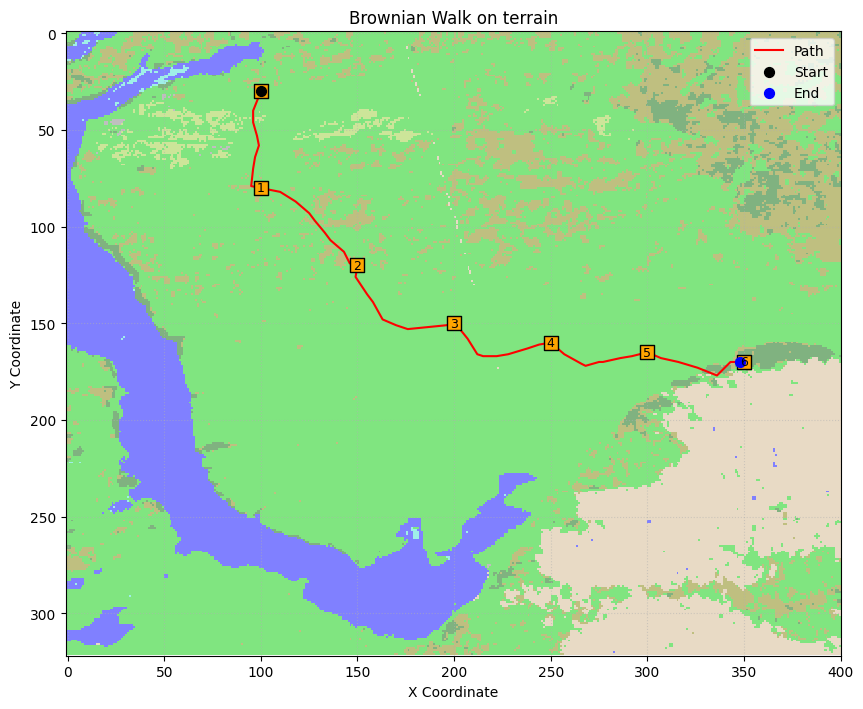

In [22]:
walker = CorrelatedWalker(T=10, terrain=terrain, kernel_mapping=kernel_mapping)
steps = [(100, 30), (100, 80), (150, 120), (200, 150), (250, 160), (300, 165), (350, 170)]
path3 = walker.generate_from_terrain_multistep(steps=steps, plot=True)
print(f"   Terrain Walk Multiple Steps: {len(path3)} Points")

### 4. Serialization

Correlated Walk dynamic programming matrices can become very large and consume significant amounts of RAM.
The `CorrelatedWalker` automatically determines whether serialization is necessary. This happens whenever the estimated memory requirement exceeds the available system RAM.

In that case, each time step is serialized to disk, ensuring that at most two timesteps are kept in memory at any given time.
The `generate` functions then return the output path where the serialized data is stored.

This path must be passed to the corresponding `backtrace` functions for the generation of walks.
Alternatively, serialization can be manually toggled by setting the `use_serialization` flag, regardless of RAM availability.


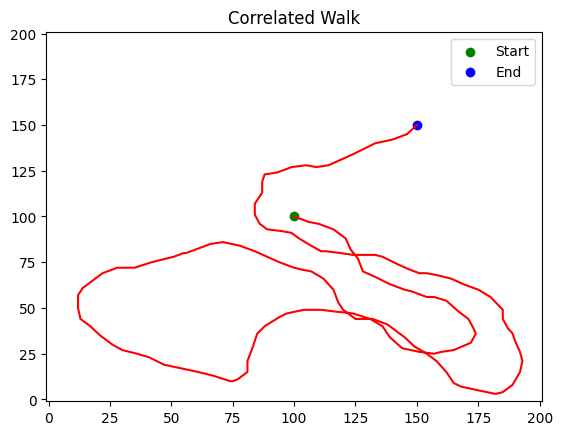

In [23]:
dp_folder_path = None
with CorrelatedWalker(T=150, W=201, H=201, D=16, S=7) as walker:
    dp_folder_path = walker.generate(start_x=100, start_y=100, use_serialization=True)
    walker.backtrace(end_x=150, end_y=150, dp_folder=dp_folder_path, plot=True)

#### The serialized data can also be reused in a different session or with another walker instance, for example:

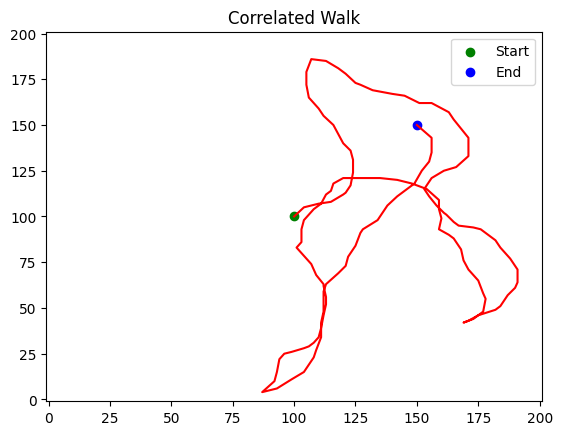

In [29]:
with CorrelatedWalker(T=150, W=201, H=201, D=16, S=7) as walker2:
    walker.set_kernel()
    walker.backtrace(end_x=150, end_y=150, dp_folder=dp_folder_path, plot=True)